In [11]:
import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import librosa

In [12]:
# path = "train_mp3s"
# mel_specs = []

# for file in os.listdir(path):
#     mp3_path = os.path.join(path, file)
#     y, sr = librosa.load(mp3_path, sr=22050)
#     mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
#     mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
#     mel_specs.append(mel_spec_db)

# mel_specs_concatenated = np.concatenate(mel_specs, axis=1)

# mean = np.mean(mel_specs_concatenated)
# std = np.std(mel_specs_concatenated)
mean = -50.217636
std = 16.921597

In [13]:
class AudioDataset(Dataset):
    def __init__(self, label_dir, song_dir, is_train):
        self.labels = self.read_labels(label_dir)
        self.song_dir = song_dir
        self.is_train = is_train

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        mp3_path = self.song_dir + f"/{idx}.mp3"
        y, sr = librosa.load(mp3_path, sr=22050)
        
        if self.is_train and random.random() < 0.3:
            y_flipped = np.flip(y,axis=0)
        else:
            y_flipped = y
        
        mel_spec = librosa.feature.melspectrogram(y=y_flipped, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_normalized = (mel_spec_db - (-50.217636)) / 16.921597
        mel_tensor = torch.tensor(mel_spec_normalized).unsqueeze(0)
        
        # Apply time masking
        if self.is_train and random.random() < 0.5:
            mel_tensor = self.time_mask(mel_tensor)
        
        # Apply frequency masking
        if self.is_train and random.random() < 0.5:
            mel_tensor = self.freq_mask(mel_tensor)
        return mel_tensor, label
    
    def freq_mask(self, spec, F=10, num_masks=1):
        test = spec.clone()
        num_mel_channels = test.shape[1]
        for i in range(0, num_masks):        
            freq = random.randrange(0, F)
            zero = random.randrange(0, num_mel_channels - freq)
            if (zero == zero + freq): return test
            mask_end = random.randrange(zero, zero + freq) 
            test[0][zero:mask_end] = test.mean()
        return test
    
    def time_mask(self, spec, time=10, num_masks=1):
        test = spec.clone()
        length = test.shape[2]
        for i in range(0, num_masks):
            t = random.randrange(0, time)
            zero = random.randrange(0, length - t) #start of the mask
            if (zero == zero + t): return test
            mask_end = random.randrange(zero, zero + t)
            test[0][:,zero:mask_end] = test.mean()
        return test
    
    def read_labels(self, label_file):
        with open(label_file, 'r') as f:
            labels = f.readlines()
        return [int(label.strip()) for label in labels]
    
    def get_class_counts(self):
        class_counts = {}
        for label in self.labels:
            if label not in class_counts:
                class_counts[label] = 0
            class_counts[label] += 1
        return class_counts #a dictionary with {label:number of datapoints}

# Create train dataset
song_dir = "train_aug"
label_dir = "train_label.txt"
train_dataset = AudioDataset(label_dir, song_dir, is_train=True)

# Calculate sizes for train and validation sets
train_size = int(0.80 * len(train_dataset))
valid_size = len(train_dataset) - train_size

# Split train set into train and validation
np.random.seed(42)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

# Create data loaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [14]:
for i, batch in enumerate(train_loader):
    feature_batch_torch, label_batch_torch = batch
    print(feature_batch_torch.shape)
    print(label_batch_torch.shape)
    if i>1:
        break

torch.Size([16, 1, 128, 130])
torch.Size([16])
torch.Size([16, 1, 128, 130])
torch.Size([16])
torch.Size([16, 1, 128, 130])
torch.Size([16])


In [15]:
class CNN(nn.Module):
    def __init__(self,in_channels=1, num_classes=4):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(8192, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        x = self.pool(nn.functional.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        valid_loss = running_loss/len(dataloader.dataset)
    accuracy = correct_predictions / total_predictions
    return accuracy, valid_loss

def predict_audio_test(test_dir, device, model, epoch):
    ids = []
    predictions = []

    for filename in os.listdir(test_dir):
        song_id = int(filename[:-4])
        song_path = os.path.join(test_dir, filename)
        y, sr = librosa.load(song_path)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_normalized = (mel_spec_db - (-50.217636)) / 16.921597
        mel_tensor = torch.tensor(mel_spec_normalized).unsqueeze(0)
        with torch.no_grad():
            input = mel_tensor.to(device)
            output = model(input.unsqueeze(0))
            _, predicted = torch.max(output, 1)

        ids.append(song_id)
        predictions.append(predicted.item())

    submission_df = pd.DataFrame({'id': ids, 'category': predictions})
    submission_df.to_csv(f'test_predictions_{epoch}.csv', index=False)

In [17]:
def plot(train_losses,valid_losses,valid_acc,num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    plt.plot(range(1, num_epochs + 1), valid_acc, label='Validation Acc')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [18]:
#mixup
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam   

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)   

In [19]:
def calculate_class_weights(dataset):
    class_counts = np.bincount(dataset)
    class_weights = 1. / class_counts
    normalized_weights = class_weights / class_weights.sum()
    return torch.FloatTensor(normalized_weights)

9508
Epoch 1/30, Train Loss: 0.8742
lr:0.001 valid_loss:0.583020544834153 valid_acc:0.7140454163162321
Epoch 2/30, Train Loss: 0.7738
lr:0.001 valid_loss:0.533521355953008 valid_acc:0.7577796467619848
Epoch 3/30, Train Loss: 0.7186
lr:0.001 valid_loss:0.4848113832000527 valid_acc:0.7674516400336417
Epoch 4/30, Train Loss: 0.6991
lr:0.001 valid_loss:0.506617207352708 valid_acc:0.7813288477712363
Epoch 5/30, Train Loss: 0.6582
lr:0.001 valid_loss:0.5744165449808183 valid_acc:0.7249789739276703
Epoch 6/30, Train Loss: 0.6421
lr:0.001 valid_loss:0.43297865402808805 valid_acc:0.8023549201009251
Epoch 7/30, Train Loss: 0.6307
lr:0.001 valid_loss:0.46868630173428905 valid_acc:0.776282590412111
Epoch 8/30, Train Loss: 0.6071
lr:0.001 valid_loss:0.3969344885234977 valid_acc:0.8313708999158957
Epoch 9/30, Train Loss: 0.5708
lr:0.001 valid_loss:0.4026486038961162 valid_acc:0.8187552565180825
Epoch 10/30, Train Loss: 0.5771
lr:0.0001 valid_loss:0.37529694858571877 valid_acc:0.832632464255677
Epoch

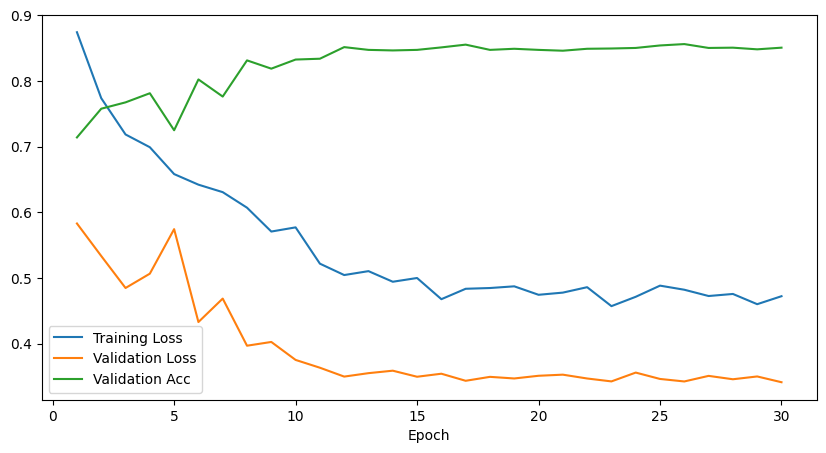

In [20]:
#train
def train(model, train_loader, valid_loader, optimizer, criterion, device, scheduler,num_epochs=5):
    model.train()
    valid_losses=[]
    train_losses=[]
    valid_acc=[]
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() # clear gradient

            #mix-up
            inputs_mixed, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha=0.4, use_cuda=False)
            outputs = model(inputs_mixed)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            loss.backward() # compute gradient
            
            optimizer.step() # run optimizer (perform model update)
            running_loss += loss.item() * inputs.size(0)
                
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")
        valid_accuracy, valid_loss = evaluate_model(model, valid_loader, criterion, device)
        scheduler.step()
        lr = optimizer.state_dict()['param_groups'][0]['lr']
        print(f"lr:{lr} valid_loss:{valid_loss} valid_acc:{valid_accuracy}")
        valid_losses.append(valid_loss)
        train_losses.append(epoch_loss)
        valid_acc.append(valid_accuracy)
        test_dir = 'test_aug'
        predict_audio_test(test_dir, device, model, epoch+1)
        # torch.save(model.state_dict(),f"CNN_model/{epoch+1}.pth")
    plot(train_losses,valid_losses,valid_acc,num_epochs)

num_classes = 4
num_epochs = 30
batch_size = 16 #defined in previous block
init_lr = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(in_channels=1, num_classes=4).to(device)

train_labels = [label for _, label in train_dataset]
print(len(train_labels))
class_weights = calculate_class_weights(train_labels)
class_weights_tensor = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, weight_decay = 0.0001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,15], gamma=0.1)
train(model, train_loader, valid_loader, optimizer, criterion, device, scheduler, num_epochs)
